# Inference resent50 by onnx
## Import required libraries

In [1]:
import os
# import cv2
import time
import numpy as np
import matplotlib.pyplot as plt


In [5]:
import torch
from torchvision import models

In [2]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: cannot open shared object file: No such file or directory']
  warnings.warn(f"file system 

In [3]:
import onnxruntime as ort

## Debugeer
### Print tf detial information

In [ ]:
# tf.debugging.set_log_device_placement(False)

### Check Tensorflow

In [ ]:
# print("Tensorflow version: ", tf.version.VERSION)

# # check TensorRT version
# print("TensorRT version: ")
# !dpkg -l | grep nvinfer

### Check Tensor core GPU
The below code check whether a Tensor-core GPU is present.

In [ ]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

## Model
### ResNet50

### Pytorch

In [138]:
# Input shape
image_height = 1280
image_width = 1920

In [139]:
model = models.resnet50(pretrained=True)
model.eval()

dummy_input = torch.randn(1, 3, image_height, image_width)

torch.onnx.export(
    model,
    dummy_input,
    "Model/resnet50_{}_{}.onnx".format(image_height, image_width),
    export_params=True,
    opset_version=10,
    do_constant_folding=True,
    input_names=['Input'],
    output_names=['Output'],
    dynamic_axes={
        'Input': {0: 'batch_size'},
        'Output' : {0: 'batch_size'}
    }
)

In [12]:
img_path = './dataset/segment-10243642118467607790_880_000_900_000/0/FRONT.jpeg'
img = image.load_img(img_path, target_size=(1280, 1920))
x = image.img_to_array(img)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
x = x[..., ::-1]
x /= 255
x[:, :, 0] -= mean[0]
x[:, :, 1] -= mean[1]
x[:, :, 2] -= mean[2]
x[:, :, 0] /= std[0]
x[:, :, 1] /= std[1]
x[:, :, 2] /= std[2]
x

array([[[ 1.1357993 ,  0.5903362 ,  0.49620935],
        [ 1.1529241 ,  0.6078432 ,  0.51363856],
        [ 1.1357993 ,  0.5903362 ,  0.49620935],
        ...,
        [-1.2616663 , -1.317927  , -1.0375599 ],
        [-1.2787911 , -1.3354341 , -1.0549891 ],
        [-1.2959158 , -1.352941  , -1.0724182 ]],

       [[ 1.1186745 ,  0.57282925,  0.47878015],
        [ 1.1529241 ,  0.6078432 ,  0.51363856],
        [ 1.1700488 ,  0.62535024,  0.5310677 ],
        ...,
        [-1.2616663 , -1.317927  , -1.0375599 ],
        [-1.2787911 , -1.3354341 , -1.0549891 ],
        [-1.2959158 , -1.352941  , -1.0724182 ]],

       [[ 1.1186745 ,  0.57282925,  0.47878015],
        [ 1.1529241 ,  0.6078432 ,  0.51363856],
        [ 1.1357993 ,  0.62535024,  0.5310677 ],
        ...,
        [-1.2616663 , -1.317927  , -1.0375599 ],
        [-1.2959158 , -1.352941  , -1.0724182 ],
        [-1.3130406 , -1.370448  , -1.0898474 ]],

       ...,

       [[-1.073294  , -1.12535   , -1.0549891 ],
        [-1

### Tensorflow

In [29]:
# Input shape
image_height = 1280
image_width = 1920

In [30]:
keras.backend.set_image_data_format('channels_first')

In [33]:
resnet50 = ResNet50(weights='imagenet')

model = Sequential(name='shaped_resnet50')
model.add(ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(3, image_height,image_width)
))
model.add(resnet50.get_layer('avg_pool'))
model.add(resnet50.get_layer('predictions'))

del resnet50

94765736/94765736 [==============================] - 2s 0us/step


In [4]:
img_path = './dataset/segment-10243642118467607790_880_000_900_000/0/FRONT.jpeg'
img = image.load_img(img_path, target_size=(1280, 1920))
x = image.img_to_array(img)
mean = [103.939, 116.779, 123.68]
x = x[..., ::-1]
x[:, :, 0] -= mean[0]
x[:, :, 1] -= mean[1]
x[:, :, 2] -= mean[2]
x

array([[[  86.061    ,   33.221    ,    8.32     ],
        [  87.061    ,   34.221    ,    9.32     ],
        [  86.061    ,   33.221    ,    8.32     ],
        ...,
        [ -53.939003 ,  -75.779    ,  -79.68     ],
        [ -54.939003 ,  -76.779    ,  -80.68     ],
        [ -55.939003 ,  -77.779    ,  -81.68     ]],

       [[  85.061    ,   32.221    ,    7.3199997],
        [  87.061    ,   34.221    ,    9.32     ],
        [  88.061    ,   35.221    ,   10.32     ],
        ...,
        [ -53.939003 ,  -75.779    ,  -79.68     ],
        [ -54.939003 ,  -76.779    ,  -80.68     ],
        [ -55.939003 ,  -77.779    ,  -81.68     ]],

       [[  85.061    ,   32.221    ,    7.3199997],
        [  87.061    ,   34.221    ,    9.32     ],
        [  86.061    ,   35.221    ,   10.32     ],
        ...,
        [ -53.939003 ,  -75.779    ,  -79.68     ],
        [ -55.939003 ,  -77.779    ,  -81.68     ],
        [ -56.939003 ,  -78.779    ,  -82.68     ]],

       ...,

      

In [12]:
img_path = './dataset/segment-10243642118467607790_880_000_900_000/0/FRONT.jpeg'
img = image.load_img(img_path, target_size=(1280, 1920))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x

array([[[[  86.061    ,   33.221    ,    8.32     ],
         [  87.061    ,   34.221    ,    9.32     ],
         [  86.061    ,   33.221    ,    8.32     ],
         ...,
         [ -53.939003 ,  -75.779    ,  -79.68     ],
         [ -54.939003 ,  -76.779    ,  -80.68     ],
         [ -55.939003 ,  -77.779    ,  -81.68     ]],

        [[  85.061    ,   32.221    ,    7.3199997],
         [  87.061    ,   34.221    ,    9.32     ],
         [  88.061    ,   35.221    ,   10.32     ],
         ...,
         [ -53.939003 ,  -75.779    ,  -79.68     ],
         [ -54.939003 ,  -76.779    ,  -80.68     ],
         [ -55.939003 ,  -77.779    ,  -81.68     ]],

        [[  85.061    ,   32.221    ,    7.3199997],
         [  87.061    ,   34.221    ,    9.32     ],
         [  86.061    ,   35.221    ,   10.32     ],
         ...,
         [ -53.939003 ,  -75.779    ,  -79.68     ],
         [ -55.939003 ,  -77.779    ,  -81.68     ],
         [ -56.939003 ,  -78.779    ,  -82.68     ]],

Before proceeding, let's quick take a look at the predictions

2023-02-27 05:16:29.120871: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8401


1/1 [==============================] - 16s 16s/step
./dataset/img0.jpg - Predicted: [('n03041632', 'cleaver', 0.34123552), ('n04008634', 'projectile', 0.02610738), ('n03804744', 'nail', 0.024527812)]
1/1 [==============================] - 0s 331ms/step
./dataset/img1.jpg - Predicted: [('n01828970', 'bee_eater', 0.16513884), ('n01833805', 'hummingbird', 0.06332261), ('n01537544', 'indigo_bunting', 0.057745554)]
1/1 [==============================] - 0s 157ms/step
./dataset/img2.jpg - Predicted: [('n02481823', 'chimpanzee', 0.33535746), ('n02480855', 'gorilla', 0.04172212), ('n02488291', 'langur', 0.039821852)]
1/1 [==============================] - 0s 142ms/step
./dataset/img3.jpg - Predicted: [('n01739381', 'vine_snake', 0.2610267), ('n01749939', 'green_mamba', 0.12854098), ('n03445777', 'golf_ball', 0.07577314)]


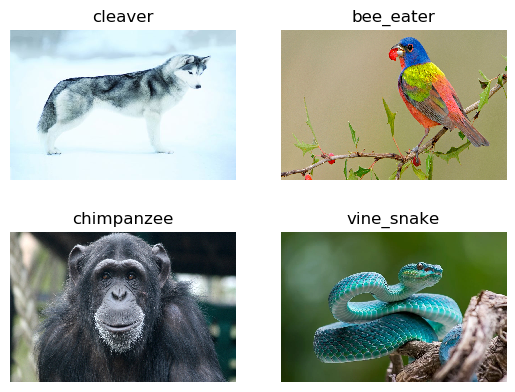

In [34]:
# testing
for i in range(4):
  img_path = './dataset/img%d.jpg'%i
  img = image.load_img(img_path, target_size=(image_height, image_width))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  
  print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

  plt.subplot(2,2,i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(decode_predictions(preds, top=3)[0][0][1])

In [ ]:
model.save('./Model/resnet50_saved_model') 

In [ ]:
## Convert model to onnx format in terminal
!python3 -m tf2onnx.convert --saved-model ./Model/resnet50_saved_model --output ./Model/resnet50_{image_width}_{image_height}.onnx

## Inference

In [128]:
# config
GPU_enable = True
inputShapes = [[224, 224]]


In [55]:
keras.backend.set_image_data_format('channels_first')

In [140]:

sessions = []
options = ort.SessionOptions()

providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if GPU_enable else ['CPUExecutionProvider']
for height, width in inputShapes:
    sessions.append({
        'shape': [height, width],
        # 'session': ort.InferenceSession("./Model/resnet50_{}_{}.onnx".format(height, width), providers=providers)})
        'session': ort.InferenceSession("./Model/resnet50.onnx".format(height, width), providers=providers)})

In [141]:
for session in sessions:
    session['in_name'] = [i.name for i in session['session'].get_inputs()]
    session['out_name'] = [i.name for i in session['session'].get_outputs()]
session['in_name']
session['out_name']

['Output']

In [122]:
# for tensorflow model
batch_size = 2

for session in sessions:
    height, width = session['shape']
    batched_input = np.zeros((batch_size, 3, height, width), dtype=np.float32)

    for i in range(batch_size):
        img_path = './dataset/img%d.jpg' % (i % 4)
        img = image.load_img(img_path, target_size=(height, width))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        batched_input[i, :] = x
    print(batched_input.shape)

    session['batch_size'] = batch_size
    session['batched_input'] = {session['in_name'][0]:batched_input}

(2, 3, 112, 112)


In [143]:
# for pytorch model
batch_size = 4

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

for session in sessions:
    height, width = session['shape']
    batched_input = np.zeros((batch_size, 3, height, width), dtype=np.float32)

    for i in range(batch_size):
        img_path = './dataset/img%d.jpg' % (i % 4)
        img = image.load_img(img_path, target_size=(height, width))
        x = image.img_to_array(img)
        x = x[..., ::-1]
        x /= 255
        x[:, :, 0] -= mean[0]
        x[:, :, 1] -= mean[1]
        x[:, :, 2] -= mean[2]
        x[:, :, 0] /= std[0]
        x[:, :, 1] /= std[1]
        x[:, :, 2] /= std[2]
        x
        batched_input[i, :] = x
    print(batched_input.shape)

    session['batch_size'] = batch_size
    session['batched_input'] = {session['in_name'][0]:batched_input}

(4, 3, 224, 224)


In [144]:
# warm up
for session in sessions:
    start = time.time()
    outputs = session['session'].run(session['out_name'], session['batched_input'])[0]
    end = time.time()
    print('Spend: {:4.1f}ms'.format((end - start) * 1000))

    session['predictions'] = decode_predictions(outputs, top=3)

Spend: 1026.1ms


In [145]:
# show result
for session in sessions:
    print(session['shape'])
    for i in range(session['batch_size']):
        print(session['predictions'][i][0][1])

[224, 224]
Siberian_husky
hummingbird
chimpanzee
brain_coral


In [28]:
# Benchmarking throughput
N_warmup_run = 50
N_run = 500

# Choose test model
session = sessions[0]

elapsed_time = []
for i in range(N_warmup_run):
  start_time = time.time()
  outputs = session['session'].run(session['out_name'], session['batched_input'])[0]
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
print('{:4.1f}ms'.format((elapsed_time.mean()) * 1000))

elapsed_time = []
for i in range(N_run):
  start_time = time.time()
  outputs = session['session'].run(session['out_name'], session['batched_input'])[0]
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
#   print('{:4.1f}ms'.format((elapsed_time.mean()) * 1000))
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Avg spend: {:4.1f}ms'.format((elapsed_time.mean()) * 1000))
print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

570.4ms
Step 0: 616.5ms
Step 50: 516.3ms
Step 100: 593.0ms
Step 150: 537.6ms
Step 200: 487.8ms
Step 250: 568.8ms
Step 300: 496.4ms
Step 350: 644.4ms
Step 400: 592.8ms
Step 450: 538.8ms
Avg spend: 543.9ms
Throughput: 7 images/s


## Slicing Img

In [4]:
class bounding_box:
    def __init__(self, x, y, distant):
        self.top = y
        self.button = y
        self.left = x
        self.right = x
        self.distant = distant
    

### Searching property
1. new point must outside the existed obstacles

In [13]:
# load data
radius = 15
obstacles = []
mfile = open("./dataset/segment-10243642118467607790_880_000_900_000/0/FRONT.txt")
start = time.time()
for index, line in enumerate(mfile):
    if index == 0: continue
    point = line[:-1].split('\t')
    x = int(point[0])
    y = int(point[1])
    distant = float(point[2])
    for obstacle in obstacles:
        if abs(obstacle.distant - distant) < 5:
            if (obstacle.top - radius) < y < (obstacle.button + radius) and (obstacle.left - radius) < x < (obstacle.right + radius):
                obstacle.top = min(obstacle.top, y)
                obstacle.button = max(obstacle.button, y)
                obstacle.left = min(obstacle.left, x)
                obstacle.right = max(obstacle.right, x)
                obstacle.distant = (obstacle.distant + distant) / 2
                break

    else:
        obstacles.append(bounding_box(x, y, distant))

# merging close obstacles
for i, obstacle_i in enumerate(obstacles):
    for j, obstacle_j in enumerate(obstacles):
        if abs(obstacle_i.distant - obstacle_j.distant) < 5 and i != j and obstacle_i.distant != 1000:
            x_flag = max(obstacle_i.button - obstacle_j.top, obstacle_j.button - obstacle_i.top) < (obstacle_i.button - obstacle_i.top) + (obstacle_j.button - obstacle_j.top) + 15
            y_flag = max(obstacle_i.right - obstacle_j.left, obstacle_j.right - obstacle_i.left) < (obstacle_i.right - obstacle_i.left) + (obstacle_j.right - obstacle_j.left) + 15
            if x_flag and y_flag:
                obstacle_i.top = min(obstacle_i.top, obstacle_j.top)
                obstacle_i.button = max(obstacle_i.button, obstacle_j.button)
                obstacle_i.left = min(obstacle_i.left, obstacle_j.left)
                obstacle_i.right = max(obstacle_i.right, obstacle_j.right)
                obstacle_i.distant = (obstacle_i.distant + obstacle_j.distant) / 2

                obstacle_j.distant = 1000

print(time.time() - start)

new_obstacles = []
for obstacle in obstacles:
    if obstacle.distant != 1000 and (obstacle.button - obstacle.top) * (obstacle.right - obstacle.left) > 56 * 56:
        new_obstacles.append(obstacle)
obstacles = new_obstacles


0.2845180034637451


In [14]:
print("[top, button, left, right, distant]")
for index, obstacle in enumerate(obstacles):
    print("{}: [{}, {}, {}, {}, {}]".format(
        index,
        obstacle.top,
        obstacle.button,
        obstacle.left,
        obstacle.right,
        obstacle.distant 
    ))

[top, button, left, right, distant]
0: [524, 792, 4, 369, 40.58521323338222]
1: [532, 1278, 1359, 1919, 15.950463563028633]
2: [558, 690, 948, 1057, 67.53485058036667]
3: [552, 816, 1146, 1882, 26.209184086274362]
4: [596, 685, 1205, 1265, 37.77350491975708]
5: [695, 786, 1072, 1165, 32.70544478204971]
6: [730, 779, 413, 526, 36.0210838738206]
7: [814, 904, 1, 118, 19.094837596939655]
8: [1022, 1061, 484, 574, 12.092424560338259]
9: [1176, 1248, 2, 105, 9.815074576500024]
10: [1164, 1241, 247, 475, 9.169299967355315]


In [15]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c

xs = []
ys = []
colors = []

mfile = open("./dataset/segment-10243642118467607790_880_000_900_000/0/FRONT.txt")
for index, line in enumerate(mfile):
    if index == 0: continue
    # if index == 6873: break
    point = line[:-1].split('\t')
    x = int(point[0])
    y = int(point[1])
    distant = float(point[2])

    xs.append(x)  # width, col
    ys.append(y)  # height, row
    colors.append(rgba(distant))

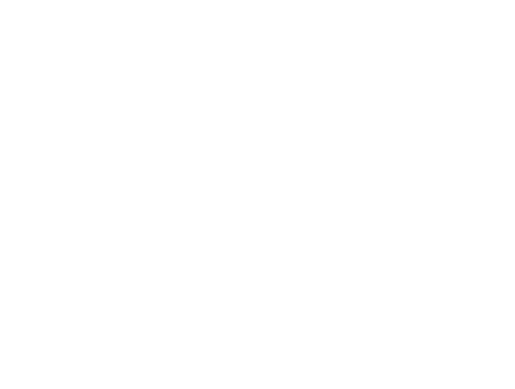

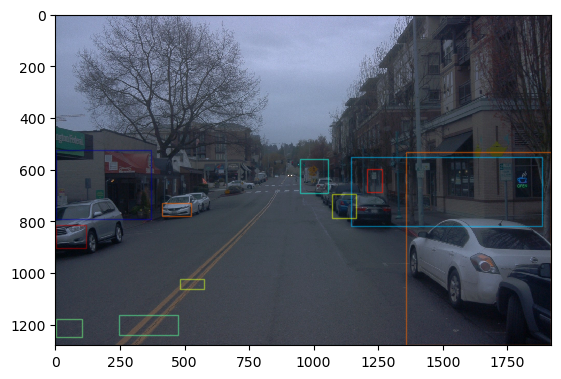

In [16]:
import matplotlib.image as mpimg
import matplotlib.patches as patches

img = mpimg.imread("./dataset/segment-10243642118467607790_880_000_900_000/0/FRONT.jpeg")

plt.grid(False)
plt.axis('off')
fig, ax = plt.subplots()

ax.imshow(img)

for obstacle in obstacles:
    if obstacle.distant == 1000: continue
    # ax.annotate([obstacle.top, obstacle.button, obstacle.left, obstacle.right], (obstacle.left, obstacle.top), color='black', fontsize=3)
    ax.add_patch(
        patches.Rectangle((obstacle.left, obstacle.top), (obstacle.right - obstacle.left), (obstacle.button - obstacle.top), linewidth=1, edgecolor=rgba(obstacle.distant), facecolor='none')
    )

plt.show()

In [ ]:
plt.imshow(img)
plt.scatter(xs, ys, c=colors, s=5.0, edgecolors="none")